In [19]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import sys
sys.path.append("../")
import torch
import torch.nn as nn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
from PIL import Image
from src.train_pm import Dataset, double_conv, LeUNet, StandardNet, EnsembleNet, EPAPLN
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
from src.preprocessing.trans_func import *
import torchvision.models as models

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
data = pd.read_csv('../all_data.csv')
data_train = data.sample(frac=0.8,random_state=17)
data_val = data.loc[~data.index.isin(data_train.index)]
files_train = list(data_train['filename'])
files_val = list(data_val['filename'])
ppm_train = list(data_train['ppm'])
ppm_val = list(data_val['ppm'])
ids_train = [i for i in range(len(files_train))]
ids_val = [i for i in range(len(files_val))]
# data = None
# data_train = None
# data_val = None
files = list(data['filename'])
ppm = list(data['ppm'])
ids = [i for i in range(len(files))]

In [33]:
model = LeUNet()
model = torch.nn.DataParallel(model).cuda()
model.load_state_dict(torch.load("../src/model_pm_china.pth"),strict=False) # on GPU

<All keys matched successfully>

In [4]:
# model = StandardNet('resnet50').cuda()
# model.load_state_dict(torch.load("../src/resnet50_pm_all.pth"),strict=False)

In [5]:
# model = StandardNet('vgg16').cuda()
# model.load_state_dict(torch.load("../src/vgg16_pm_all.pth"),strict=False)

<All keys matched successfully>

In [6]:
# model = EPAPLN().cuda()
# model.load_state_dict(torch.load("../src/epapln_pm_all.pth"),strict=False)

In [7]:
# model = EnsembleNet().cuda()
# model.load_state_dict(torch.load("../src/ensemble_pm_all.pth"),strict=False)

In [34]:
dataset = Dataset(ids, files, ppm, transforms.Compose([transforms.Resize((256,256)),transforms.ToTensor(),transforms.Normalize(mean=[0.5231, 0.5180, 0.5115],std=[0.2014, 0.2018, 0.2100]),])) # normalize
loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False, num_workers=12)

In [35]:
model = model.eval()

In [36]:
actual = []
preds = []
for x, y in loader:
    y = y.float()
    x = x.cuda(non_blocking=True)
    y = y.cuda(non_blocking=True)

    x_var = torch.autograd.Variable(x)
    y_var = torch.autograd.Variable(y)

    yhat = model(x_var).squeeze()
    actual += [y_var.cpu().detach().numpy()]
    preds += [yhat.cpu().detach().numpy()]

In [37]:
actual = np.concatenate(actual)

In [38]:
preds = np.concatenate(preds)

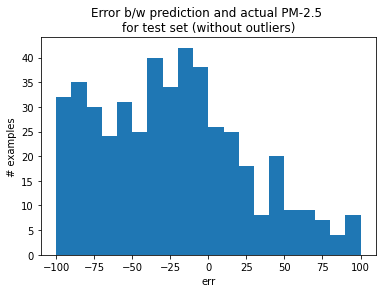

-83.483
153.47891


In [39]:
err = np.array(preds)-np.array(actual)
err_val = err[np.array(ids_val)]
# err_val = err
plt.hist(err_val, bins=20,range=(-100,100))
plt.title("Error b/w prediction and actual PM-2.5 \nfor test set (without outliers)")
plt.xlabel('err')
plt.ylabel('# examples')
plt.savefig('err_full.png')
plt.show()
print(np.mean(err_val))
print(np.std(err_val))

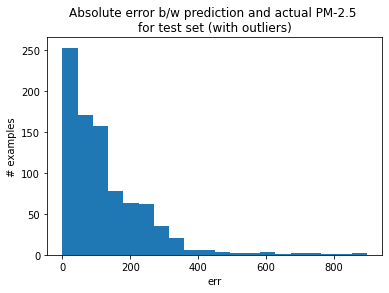

124.29471
122.78441


In [40]:
plt.hist(np.abs(err_val), bins=20)
plt.title("Absolute error b/w prediction and actual PM-2.5 \nfor test set (with outliers)")
plt.xlabel('err')
plt.ylabel('# examples')
plt.savefig('err_val.png')
plt.show()
print(np.mean(np.abs(err_val)))
print(np.std(np.abs(err_val)))

In [41]:
id_china = []
id_delhi = []
for index, row in data_val.iterrows():
    filename = row['filename']
    if filename.startswith('Shanghai1') or filename.startswith('Shanghai2') or filename.startswith('Shanghai3') or filename.startswith('Beijing'):
        id_china.append(index)
    else:
        id_delhi.append(index)

print(len(id_china))
print(len(id_delhi))

450
420


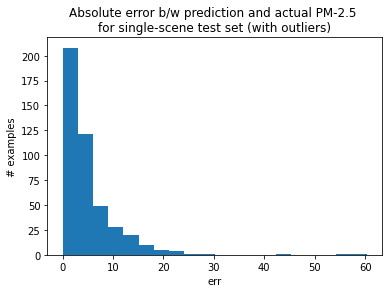

5.1605663
6.186262


In [42]:
err_china = np.abs(err[np.array(id_china)]) #err_val,err?
err_delhi = np.abs(err[np.array(id_delhi)])
plt.hist(err_china, bins=20)
plt.title("Absolute error b/w prediction and actual PM-2.5 \nfor single-scene test set (with outliers)")
plt.xlabel('err')
plt.ylabel('# examples')
plt.savefig('err_china.png')
plt.show()
print(np.mean(err_china))
print(np.std(err_china))

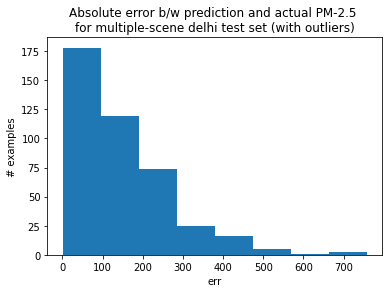

143.04773
120.64816


In [43]:
plt.hist(err_delhi, bins=8)
plt.title("Absolute error b/w prediction and actual PM-2.5 \nfor multiple-scene delhi test set (with outliers)")
plt.xlabel('err')
plt.ylabel('# examples')
plt.savefig('err_delhi.png')
plt.show()
print(np.mean(err_delhi))
print(np.std(err_delhi))

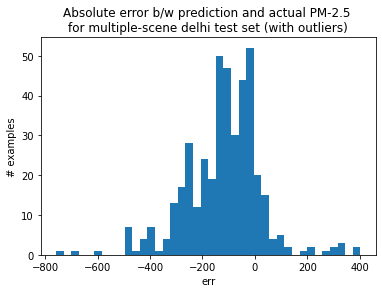

-119.26564
144.20242


In [44]:
plt.hist(err[np.array(id_delhi)], bins=40)
plt.title("Absolute error b/w prediction and actual PM-2.5 \nfor multiple-scene delhi test set (with outliers)")
plt.xlabel('err')
plt.ylabel('# examples')
plt.savefig('err_delhi.png')
plt.show()
print(np.mean(err[np.array(id_delhi)]))
print(np.std(err[np.array(id_delhi)]))